In [1]:
import argparse
import os
import copy
import time
from enum import Enum
import importlib

import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torch.utils.data import Subset
import attention
# import webdataset as wds

import datetime
import utils
import numpy as np
import math
import einops
import random
import pandas as pd

import wandb 
import sys 
import glob


# Argparse

In [2]:
parser = argparse.ArgumentParser(description='GMM L2L Training with Sequence Model')
parser.add_argument('--data', metavar='DIR', nargs='?', default='./data',
                    help='path to dataset (default: imagenet)')
parser.add_argument('--cache', default='./cache',
                    help='path to cached files (e.g. for previous random weights)')
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--wandb_group_name",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--resume",type=str,default=None,
    help="analyze a previous run"
)
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training.')
parser.add_argument('--epochs', default=90, type=int,  
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=64, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')                         
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--optimizer', default='SGD', type=str, 
                    choices = ['SGD', 'Adam'],
                    help='optimizer')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--wd', '--weight-decay', default=1e-5, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('--arch', '-a', metavar='ARCH', default='mlp',
                    help='model architecture (default: mlp)')
parser.add_argument('--gpt_bias', default="True", type=str,
                    help='whether to include bias in GPT')
parser.add_argument('--num_hidden_features', default=1, type=int,
                    help='num_hidden_features')
parser.add_argument('--num_layers', default=1, type=int,
                    help='num_layers in transformer')
parser.add_argument('--len_context', default=1, type=int,
                    help='number of in-context images in sequence')
parser.add_argument('--SLURM_ARRAY_TASK_ID', default=1, type=int,
                    help='SLURM_ARRAY_TASK_ID')
parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')  
parser.add_argument('--D_sum', default=1000, type=int, help='number of visible+ hidden features')
parser.add_argument('--D_visible_frac', default=1.0, type=float, help='fraction of features visible') 
parser.add_argument('--K', default=1, type=int, 
                    help='number of tasks')
parser.add_argument('--input_covariance', default="False", type=str,
                    help='input covariance matrix')
parser.add_argument('--coarse_graining', default="abstop", type=str,
                    help='coarse graining method')
parser.add_argument('--sigma_xi', default=1.0, type=float, help='noise level')
parser.add_argument('--rho_minus', default=0.5, type=float, help='rho_minus, spectral weights')
parser.add_argument(
            '--fileprefix', 
            default="",
            type=str, 
            action='store') 


# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    arch = "pytorch_transformer"
    # arch = "transformer"
    gpt_bias="True"
    lr=1e-4
    optimizer="Adam"
    epochs=500
    D_visible_frac=0
    len_context=100
    jupyter_args = f"--data ./cache --fileprefix jan29_2pm  --SLURM_ARRAY_TASK_ID 0 --batch-size 256 --optimizer {optimizer} --lr {lr} --wd 0.0  --epochs {epochs} --arch gpt --gpt_bias {gpt_bias} --num_hidden_features 128 --num_layers 8 --len_context {len_context} --K 1048576 --D_sum 32 --D_visible_frac {D_visible_frac} --sigma_xi 0.5 --coarse_graining abstop --no-wandb_log --wandb_project renormalization --wandb_group_name linreg_nov13_specgen_bias_Dsum_32"
    
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()


--data ./cache --fileprefix jan29_2pm  --SLURM_ARRAY_TASK_ID 0 --batch-size 256 --optimizer Adam --lr 0.0001 --wd 0.0  --epochs 500 --arch gpt --gpt_bias True --num_hidden_features 128 --num_layers 8 --len_context 100 --K 1048576 --D_sum 32 --D_visible_frac 0 --sigma_xi 0.5 --coarse_graining abstop --no-wandb_log --wandb_project renormalization --wandb_group_name linreg_nov13_specgen_bias_Dsum_32


# Exp. settings

In [3]:
if args.fileprefix == "jan17_2pm":
    resumes = [
            "./cache/linreg_nov19_specgen_bias_Dsum__scheduler_None_K_1024_no_layernorm_input_opt_Adam_lr_1e-4_gpt_bias_True_epochs_500_visible_32_K_1024_D_64_L_100_hidden_128_coarse_abstop_1732079333.0764203.pkl",
            "./cache/linreg_nov19_specgen_bias_Dsum__scheduler_None_K_1048576_no_layernorm_input_opt_Adam_lr_1e-4_gpt_bias_True_epochs_500_visible_32_K_1048576_D_64_L_100_hidden_128_coarse_abstop_1732079442.9435685.pkl",
            # "./cache/linreg_nov19_specgen_bias_Dsum__scheduler_None_K_32768_no_layernorm_input_opt_Adam_lr_1e-4_gpt_bias_True_epochs_500_visible_32_K_32768_D_64_L_100_hidden_128_coarse_abstop_1732079299.9278684.pkl",
            # "./cache/linreg_nov19_specgen_bias_Dsum__scheduler_None_K_32_no_layernorm_input_opt_Adam_lr_1e-4_gpt_bias_True_epochs_500_visible_32_K_32_D_64_L_100_hidden_128_coarse_abstop_1732079383.3274248.pkl"
            ]
    args.resume = resumes[args.SLURM_ARRAY_TASK_ID % len(resumes)]
    coarse_grainings = [ "abstop","shrink_norm", "aniso_highvariance_shrink_k", "aniso_lowvariance_shrink_k", "aniso_highvariance_vary_cos", "aniso_lowvariance_vary_cos"] 
    args.coarse_graining = coarse_grainings[args.SLURM_ARRAY_TASK_ID // len(resumes)] 
    # args.coarse_graining = "vary_cos_alignment"
    if args.coarse_graining in ["abstop","shrink_norm", "vary_cos_alignment"]:
        args.input_covariance = "False"
    else: 
        args.input_covariance = "anisotropic"
         
    # args.coarse_graining = "aniso_highvariance_vary_cos"
    # args.coarse_graining = "aniso_highvariance_shrink_k"
    
    # args.resume = "./cache/linreg_nov19_specgen_bias_Dsum__scheduler_None_K_1048576_no_layernorm_input_opt_Adam_lr_1e-4_gpt_bias_True_epochs_500_visible_32_K_1048576_D_64_L_100_hidden_128_coarse_abstop_1732079442.9435685.pkl"
elif args.fileprefix == "jan23_2pm":
    resumes = [
            "./cache/linreg_nov19_specgen_bias_Dsum__scheduler_None_K_1024_no_layernorm_input_opt_Adam_lr_1e-4_gpt_bias_True_epochs_500_visible_32_K_1024_D_64_L_100_hidden_128_coarse_abstop_1732079333.0764203.pkl",
            "./cache/linreg_nov19_specgen_bias_Dsum__scheduler_None_K_1048576_no_layernorm_input_opt_Adam_lr_1e-4_gpt_bias_True_epochs_500_visible_32_K_1048576_D_64_L_100_hidden_128_coarse_abstop_1732079442.9435685.pkl",
            ]
    args.resume = resumes[args.SLURM_ARRAY_TASK_ID % len(resumes)]
    coarse_grainings = [ "abstop","shrink_norm", "vary_cos_alignment"]
    args.coarse_graining = coarse_grainings[args.SLURM_ARRAY_TASK_ID // len(resumes)] 
    if args.coarse_graining == "abstop":
        args.perturbation_parameter_ranges = np.arange(0.1, 1.1, 0.1)
    elif args.coarse_graining == "shrink_norm":
        args.perturbation_parameter_ranges = np.sqrt(np.arange(0.1, 1.1, 0.1))
    elif args.coarse_graining == "vary_cos_alignment":
        args.perturbation_parameter_ranges = np.arange(0.5, 1.01, 0.05)
elif args.fileprefix == "jan29_2pm":
    args.resume = "./cache/linreg_feb_17_aniso_datascale_1.0_lr_1e-5_epochs_10000_permute_input_dims_transformer_1739777972.8413577.pkl"
    coarse_grainings = [ "aniso_highvariance_vary_cos", "aniso_highvariance_shrink_k", "aniso_lowvariance_shrink_k", "aniso_lowvariance_vary_cos"] 
    args.coarse_graining = coarse_grainings[args.SLURM_ARRAY_TASK_ID]
    if "shrink_k" in args.coarse_graining:
        args.perturbation_parameter_ranges = np.sqrt(np.arange(0.0, 1.1, 0.1))
    elif "vary_cos" in args.coarse_graining:
        args.perturbation_parameter_ranges = np.arange(0.5, 1.01, 0.05)
    args.input_covariance = "anisotropic"
print ("resume",args.resume, "coarse_graining",args.coarse_graining)
# assert args.K % args.L == 0, "K must be divisible by L" 

if args.resume:
    r = utils.load_file_pickle(args.resume)
    
    print(f"Resuming from {args.resume}")
    print (r.keys())
    args.sigma_xi = r["args"]["sigma_xi"]
args.seed = r["args"]["seed"]

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Local Rank for distributed training
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)
print("args:\n",vars(args))
# setup weights and biases (optional)
if local_rank==0 and args.wandb_log: # only use main process for wandb logging
    print(f"wandb {args.wandb_project} run")
    wandb.login(host='https://stability.wandb.io') # need to configure wandb environment beforehand
    wandb_model_name = f"{args.fileprefix}_K_{args.K}_D_{args.D_sum}_L_{args.len_context}_hidden_{args.num_hidden_features}_coarse_{args.coarse_graining}"
    wandb_config = vars(args)
    
    print("wandb_id:",wandb_model_name)
    wandb.init(
        project=args.wandb_project,
        name=wandb_model_name,
        config=wandb_config,
        resume="allow",
        group=args.wandb_group_name
    )
    wandb.config.local_file_dir = wandb.run.dir 
else:
    record = {
        "args": vars(args),
        "logs": []
    }


resume ./cache/linreg_feb_17_aniso_datascale_1.0_lr_1e-5_epochs_10000_permute_input_dims_transformer_1739777972.8413577.pkl coarse_graining aniso_highvariance_vary_cos
Resuming from ./cache/linreg_feb_17_aniso_datascale_1.0_lr_1e-5_epochs_10000_permute_input_dims_transformer_1739777972.8413577.pkl
dict_keys(['args', 'logs', 'model'])
LOCAL RANK  0
args:
 {'data': './cache', 'cache': './cache', 'wandb_log': False, 'wandb_project': 'renormalization', 'wandb_group_name': 'linreg_nov13_specgen_bias_Dsum_32', 'resume': './cache/linreg_feb_17_aniso_datascale_1.0_lr_1e-5_epochs_10000_permute_input_dims_transformer_1739777972.8413577.pkl', 'seed': 4052934, 'epochs': 500, 'batch_size': 256, 'workers': 4, 'optimizer': 'Adam', 'lr': 0.0001, 'momentum': 0.9, 'weight_decay': 0.0, 'arch': 'gpt', 'gpt_bias': 'True', 'num_hidden_features': 128, 'num_layers': 8, 'len_context': 100, 'SLURM_ARRAY_TASK_ID': 0, 'no_cuda': False, 'D_sum': 32, 'D_visible_frac': 0.0, 'K': 1048576, 'input_covariance': 'anisotr

In [4]:
class Sequence(torch.utils.data.Dataset):
    def __init__(self, K, D,  
                 len_context = 1,
                 scale=0.5,
                len_data = 60000, skip_generating_betas=False,
                input_covariance = None, is_iso = "True"
                ):

        # if K < 40000:
        self.len_context = len_context
        self.D = D
    
        # x = rng.standard_normal((K, D)) * (1.0 / np.sqrt(D)) # shape: (K, D) 
        self.scale = scale
        
        self.K = K 
        self.D = D
        self.len_data = len_data
        if is_iso == "True":
            self.input_covariance_L = None
            if skip_generating_betas == False:
                true_betas = torch.randn((K, D)) * scale #* (1.0 / np.sqrt(D)) # shape: (K, D)
                self.true_betas = true_betas
        else:
            print ("anisotropic case")
            sminus = 0.1
            splus = 1.0
            data_scale = 1.0 / D
            # The proportion of eigenvalues at s₋ should be ρ₋
            rho_minus = 0.5
            # The proportion of eigenvalues at s₊ should be 1-ρ₋
            input_covariance = torch.eye(D)
            
            # Calculate number of eigenvalues for each mode 
            num_minus = int(D * rho_minus)
            num_plus = D - num_minus
            
            # Create diagonal matrix of eigenvalues
            eigenvalues = np.concatenate([
                np.ones(num_plus) * splus,
                np.ones(num_minus) * sminus
            ]) * data_scale
            
            # Generate random orthogonal matrix
            # Q = np.linalg.qr(np.random.randn(D_sum, D_sum))[0]
            
            # Construct covariance matrix 
            # input_covariance = torch.tensor(Q @ np.diag(eigenvalues) @ Q.T, dtype=torch.float32) 
            # input_covariance = torch.tensor(np.diag(eigenvalues), dtype=torch.float32) 
            # self.input_covariance_L = torch.linalg.cholesky(input_covariance)  
            # self.input_covariance = input_covariance.to(device)  
            self.input_covariance_L = torch.sqrt(torch.tensor(eigenvalues, dtype=torch.float32))
            if skip_generating_betas == False:
                true_betas = torch.randn((K, D)) #* (1.0 / np.sqrt(D)) # shape: (K, D)
                self.true_betas = true_betas 
            self.true_betas[:,num_plus:] = self.true_betas[:,num_plus:] * np.sqrt(splus / sminus)
            self.permute_input_dimensions = False # whether to permute input dimensions
            print ("self.input_covariance_L", self.input_covariance_L.shape, self.input_covariance_L) 
            print ("D", D, "num_plus", num_plus, "num_minus", num_minus, "rho_minus", rho_minus, "data_scale", data_scale)
            args.sigma_xi =  np.sqrt(D * data_scale) 
            
    def __len__(self):
        return self.len_data

    def __getitem__(self, task: int):
        task_ind = torch.randint(0, self.K, (1,)).item()
        beta_incontext = self.true_betas[task_ind].unsqueeze(1) # shape: (D, 1)
        if self.input_covariance_L is None:
            x = torch.randn((self.len_context, self.D)) * self.scale  # shape: (self.len_context, D) * (1.0 / np.sqrt(self.D))
        else: 
            x = torch.randn((self.len_context, self.D)) * self.input_covariance_L 
            if self.permute_input_dimensions == True: 
                input_features_permutation = torch.randperm(self.D)
                # input_covariance_L = self.input_covariance_L[input_features_permutation]
                beta_incontext = beta_incontext[input_features_permutation] 
                x = x[:, input_features_permutation] # permute input dimensions
             
             
            
            # x = torch.matmul(x, self.input_covariance_L.T) 
        noise = torch.randn((self.len_context, 1)) * args.sigma_xi
        y = torch.matmul(x, beta_incontext) + noise

        # concat x and y 
        samples = x#torch.cat([x, y], axis = 1) # shape: (self.len_context, D+1)
        # ytest = samples[-1, -1].clone() 
        # samples[-1, -1] = 0.0 # remove ytest from samples 
         
          
        return samples.type(torch.float32), y.type(torch.float32), beta_incontext.type(torch.float32)#, torch.randperm(self.D)


In [5]:
# importlib.reload(gpt)
import gpt
criterion = nn.MSELoss().to(device)
# define the model, optimizer, and scheduler, and criterion
if args.arch == "causal_transformer_embed":
    nheads = 1 # np.clip(args.num_hidden_features // 8, 1, 8)
    model = attention.MultiLayerTransformer(x_dim=args.D_sum,                   
                                  mlp_dim=args.num_hidden_features, 
                                  num_layers = args.num_layers
                                  ).to(device)
if args.arch == "gpt":
    import gpt 
    config = gpt.GPTConfig(
        block_size = r["args"]["len_context"],
        input_size = r["args"]["D_sum"],
        n_embd=r["args"]["num_hidden_features"],
        n_layer=r["args"]["num_layers"],
        bias = r["args"]["gpt_bias"] == "True"
    )
    model = gpt.GPT(config, criterion).to(device)

# load model from checkpoint
if args.resume:
    print(f"Loading model from {args.resume}")
    model.load_state_dict(r["model"]) 
    
if args.optimizer == 'SGD': 
    optimizer = torch.optim.SGD(model.parameters(),  
                            lr=args.lr, 
                            weight_decay=args.weight_decay
                            )
    
elif args.optimizer == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(),  
                            lr=args.lr, 
                            weight_decay=args.weight_decay
                            )
else:
    raise ValueError("optimizer not recognized")
iters_per_epoch = 1000
# scheduler = StepLR(optimizer, step_size=50, gamma=0.7)
scheduler = OneCycleLR(optimizer, max_lr=args.lr, 
                       total_steps=args.epochs * iters_per_epoch, 
                       pct_start=0.5,
                       steps_per_epoch=iters_per_epoch, epochs=args.epochs)



number of parameters: 1616579
Loading model from ./cache/linreg_feb_17_aniso_datascale_1.0_lr_1e-5_epochs_10000_permute_input_dims_transformer_1739777972.8413577.pkl


In [6]:
# import matplotlib.pyplot as plt
# plt.plot([i["lr"] for i in r["logs"]])
# plt.xlabel("epoch")
# plt.ylabel("learning rate")
# plt.savefig(f"./analysis/lr_{args.resume.split('/')[-1]}.png")
# plt.show()
# plt.plot([i["iwl_indistribution_loss_99"] for i in r["logs"]])
# plt.xlabel("epoch")
# plt.ylabel("in-distribution loss")
# plt.savefig(f"./analysis/in_distribution_loss_{args.resume.split('/')[-1]}.png")
# plt.show()



In [7]:
def get_data_loaders (args, len_context, D_sum):
    # define the dataset
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.batch_size}
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    if use_cuda:
        cuda_kwargs = {'num_workers': args.workers,
                        "shuffle": True,
                        'pin_memory': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    train_dataset = Sequence(K=args.K, D=D_sum, len_context=len_context, len_data = args.batch_size * iters_per_epoch,
                            scale =1.0, input_covariance = None)
                            
    if args.input_covariance == "anisotropic":
        print ("anisotropic case")
        input_covariance = "anisotropic"
    else:
        input_covariance = None
        
    
    # iwl_dataset = Sequence(K=args.K, D=args.D_sum, len_context=args.len_context, len_data = 1000)
    # iwl_dataset.true_betas = train_dataset.true_betas
    icl_test_dataset = Sequence(K=1000, D=D_sum, len_context=len_context, len_data = 10000,
                                scale = r["args"]["data_scale"], is_iso = r["args"]["is_iso"] ) 
    # iwl_test_dataset = Sequence(K=args.K, D=D_sum, len_context=len_context, len_data = 10000, skip_generating_betas = True,
    #                             scale = args.data_scale, is_iso = args.is_iso )
    # iwl_test_dataset.true_betas = train_dataset.true_betas

    train_sampler = None
    val_sampler = None 
    # train_loader = torch.utils.data.DataLoader(train_dataset, 
    #                                             sampler=train_sampler, 
    #                                             **train_kwargs) 
    icl_test_loader = torch.utils.data.DataLoader(icl_test_dataset,
                                                sampler=val_sampler,
                                                **test_kwargs)  
    # iwl_test_loader = torch.utils.data.DataLoader(iwl_test_dataset,
    #                                             sampler=val_sampler,
    #                                             **test_kwargs) 
    return icl_test_loader, None # iwl_test_loader

In [8]:
def get_ridge_preds(seq, target, xtest, lam=1e-5):
    """
    Predict the next time step using ridge regression
    yhat = (X^T X + lam I)^{-1} X^T y
    :params 
    seq: (batch_size, len_context, D)
    target: (batch_size, len_context, 1)
    xtest: (batch_size, 1, D)
    lam: regularization parameter
    """
    seqT = seq.permute(0, 2, 1) # batch_size x D x len_context
    ridge_matrix = torch.matmul(seqT, seq) # batch_size x D x D
    ridge_matrix += torch.eye(ridge_matrix.size(1), device=ridge_matrix.device) * lam
    seqT_Y = torch.matmul(seqT, target) # batch_size x D x 1
    w_ridge = torch.linalg.solve(ridge_matrix, seqT_Y) # batch_size x D x 1
    preds = torch.matmul(xtest, w_ridge).squeeze(-1) # batch_size x 1 x 1
    return preds 

def get_ridge_preds_seq(seq, target, lam):
    """ 
    For each time step, predict the next time step using ridge regression
    using the previous time steps as features
    """
    B, N, D = seq.size() 
    preds = []
    for _i in range(1, N):
        preds.append(get_ridge_preds(seq[:, :_i, :], target[:, :_i, :], seq[:, _i: _i + 1, :], lam=lam))
    return torch.stack(preds, dim=1)

# Generate OOD data

anisotropic case
anisotropic case
self.input_covariance_L torch.Size([32]) tensor([0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768,
        0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.0559, 0.0559,
        0.0559, 0.0559, 0.0559, 0.0559, 0.0559, 0.0559, 0.0559, 0.0559, 0.0559,
        0.0559, 0.0559, 0.0559, 0.0559, 0.0559])
D 32 num_plus 16 num_minus 16 rho_minus 0.5 data_scale 0.03125
coarse_graining standard


/scratch/gpfs/qanguyen/learning_to_learn/l2l/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


output tensor([ 1.3726e-02, -3.1068e-01, -3.1705e-02,  8.1055e-01, -3.5060e-02,
        -1.9931e+00, -2.2108e-02,  2.7222e+00,  5.8177e-03, -2.4524e+00,
         1.4482e-01, -1.9145e-01,  2.3917e-01,  2.2962e+00, -1.8429e-01,
        -6.1991e-01,  1.7942e-01,  1.8702e-01,  6.6520e-02,  9.7453e-01,
        -5.8325e-02, -1.2601e+00,  3.7265e-01,  5.5860e-01,  2.9302e-01,
         4.8642e-02, -1.5104e-01, -2.2144e-01,  2.1807e-01, -5.8751e-01,
         6.6237e-02,  1.3185e+00, -1.3567e-01,  7.5999e-01, -2.6166e-01,
        -7.2273e-01,  1.9319e-01,  1.3015e+00,  4.1917e-01,  1.2174e-01,
         7.5269e-01,  3.5477e-01, -1.1402e-02,  2.0688e-01,  4.5256e-02,
        -8.5029e-01,  1.3600e-01,  1.2496e+00, -2.6674e-01,  1.3561e-01,
         2.5258e-01,  1.3784e+00, -3.3366e-01,  1.7381e-01, -1.9436e-02,
        -8.7383e-01,  6.5796e-01,  1.4734e+00, -8.1585e-01, -1.0393e+00,
         6.2579e-01,  2.4969e+00,  7.5237e-01,  9.5084e-01, -1.1036e-01,
         1.1440e+00, -6.9973e-01, -2.2371e+0

NameError: name 'w' is not defined

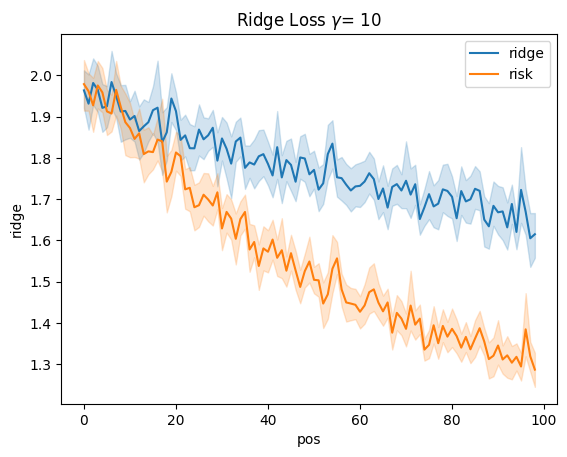

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
def analyze_dataset(xs, ys, bs, dataloader, args):

    SNRs = []
    pi_pluses = []
    pi_minuses = []
    train_dataset = dataloader.dataset # get the dataset from the dataloader
    for i in range(len(xs)):
        x, b = xs[i], bs[i]
         
        if i == 0:
            print ("x", x.shape, "y", ys[0].shape, "b", b.shape)
            # shuffle x and b according to perm 
            # x = x[:, perm] 
            # b = b[perm]
            print ( torch.matmul(x, b).shape, ys[0].shape)
            plt.scatter(torch.matmul(x, b).detach().cpu(), ys [0].flatten())
            plt.xlabel (r"$\beta^T x$")
            plt.ylabel (r"$y = \beta^T x + \varepsilon$")
            plt.show()
            print(b.flatten())
            plt.hist (b[:16].flatten().cpu().numpy(), bins = 5, alpha = 0.5, label = "positive")
            plt.hist (b[16:].flatten().cpu().numpy(), bins = 5, alpha = 0.5, label = "negative")
            plt.title("b, positive and negative components")
            plt.legend()
            plt.show()
            # print("x", x.shape, "y", y.shape, "b", b.shape)
            plt.hist (x[:,:16].flatten().cpu().numpy(), bins = 5, alpha = 0.5, label = "positive")
            plt.hist (x[:,16:].flatten().cpu().numpy(), bins = 5, alpha = 0.5, label = "negative")
            plt.title("x, positive and negative components")
            plt.legend()

            plt.show()  
            

            
            
        # compute projection of beta onto positive component 
        beta_plus = b.clone() 
        beta_plus[16:] = 0.0 
        # compute projection of beta onto negative component
        beta_minus = b.clone()
        beta_minus[:16] = 0.0
        # compute signal to noise ratio
        
        SNR =  torch.matmul(b.T, (train_dataset.input_covariance_L * train_dataset.input_covariance_L * b.squeeze(1) ).unsqueeze(1)) / (args.sigma_xi**2)
        # print( "b", b.T.shape, "train_dataset.input_covariance_L",  (train_dataset.input_covariance_L * train_dataset.input_covariance_L * b.squeeze(1) ).unsqueeze(1).shape)
        # w
        # print(b.flatten()[:10])
        SNRs.append(SNR.item())

        denom = torch.matmul(b.T, (train_dataset.input_covariance_L * train_dataset.input_covariance_L * b.squeeze(1) ).unsqueeze(1)).item()
        pi_plus = torch.matmul (beta_plus.T, (train_dataset.input_covariance_L * train_dataset.input_covariance_L * beta_plus.squeeze(1) ).unsqueeze(1)) / denom
        # pi minus =
        pi_minus = torch.matmul (beta_minus.T, (train_dataset.input_covariance_L * train_dataset.input_covariance_L * beta_minus.squeeze(1) ).unsqueeze(1)) / denom
        pi_pluses.append(pi_plus.item())
        pi_minuses.append(pi_minus.item())
        # print ("(b * train_dataset.input_covariance_L * train_dataset.input_covariance_L * b).sum()", (b * train_dataset.input_covariance_L * train_dataset.input_covariance_L * b).sum()) 

    plt.hist(SNRs, bins = 100)
    plt.title("SNR distribution")
    plt.show()
    # print(train_dataset.input_covariance_L * train_dataset.input_covariance_L * 32)
    print("mean SNR", np.mean(SNRs))
    # print (16*(10 / (32 * np.sqrt(1)
    # print("ys", len(ys),ys[0], ys[0].shape)
    ys = torch.cat(ys, dim=0).cpu().numpy().flatten()
    plt.hist(ys, bins = 100)
    plt.title("y distribution")
    plt.show()
    print("pi_pluses", pi_pluses) 
    print( "pi_minuses", pi_minuses)
    plt.hist(pi_pluses, bins = 10)
    plt.title("pi plus distribution")
    plt.xlim(-0.1, 1.1)
    plt.show()
    plt.hist(pi_minuses, bins = 10)
    plt.title("pi minus distribution")
    plt.xlim(-0.1, 1.1)
    plt.show()
    
        
        
def validate_gradient_descent(val_loader, model, args, D_visible, len_context, criterion, device, coarse_graining="standard"):
    """
    D_visible: concept shift parameter, lower means stronger concept shift
        must be a float between 0 and 1
    """
    assert 0 <= D_visible <= 1+1e-2, f"D_visible {D_visible} must be between 0 and 1"
    print("coarse_graining", coarse_graining)
    test_losses = [utils.AverageMeter('Loss', ':.4e') for _ in range(len_context)]
    training_beta_norm = utils.AverageMeter('Training Beta Norm', ':.4e')
    cos_theta_avg = utils.AverageMeter('Cosine Theta', ':.4e')
    input_covariance_L = val_loader.dataset.input_covariance_L.to(device)
    cos_theta = torch.nn.CosineSimilarity(
                    dim=1, eps=1e-6)
    model.eval() # switch to eval mode
    eps = 1e-5
    xs, ys, bs = [], [], []
    ridge_losses = defaultdict(list)
    with torch.no_grad():
        for i, (seq, target, _true_beta) in enumerate(val_loader):
            seq, target, _true_beta = seq.to(device), target.to(device), _true_beta.to(device)
        
            B, N, D = seq.size()
            if coarse_graining == "absbot":
                # true_beta: shape (B, D)
                true_beta = _true_beta.squeeze(2)
                argsort_beta_visible = torch.argsort(torch.abs(true_beta), dim=-1)[:, :D_visible] # sort each row of true_beta by absolute value, shape (B, D_visible)
                test_beta_visible = torch.gather(true_beta, dim=1, index=argsort_beta_visible) # shape (B, D_visible)
                x_test_visible = torch.gather(seq[:, -1, :].squeeze(1), dim=1, index=argsort_beta_visible) # shape (B, D_visible) 
                
                new_target = torch.matmul(x_test_visible.unsqueeze(1), test_beta_visible.unsqueeze(2)).squeeze(2) 
                new_target = new_target.squeeze(1)
                # if args.sigma_xi > 1e-5:
                    # print  ("-D_visible", -D_visible, "argsort_beta_visible", argsort_beta_visible.shape, "test_beta_visible", test_beta_visible.shape)
                sigma_test_xi = torch.pow(args.sigma_xi ** 2 + torch.matmul(true_beta.unsqueeze(1), true_beta.unsqueeze(2)) \
                                        - torch.matmul(test_beta_visible.unsqueeze(1), test_beta_visible.unsqueeze(2))+eps, 0.5).squeeze(2).squeeze(1) # shape (B)
                # print ("sigma_test_xi", sigma_test_xi)
                new_target += torch.randn(new_target.size(0), device=device) * sigma_test_xi # shape (B, 1) 
                target[:, -1, 0] = new_target
                
            elif coarse_graining == "abstop":
                true_beta = _true_beta.squeeze(2) # shape (B, D)
                # print ("true_beta", true_beta.shape)
                num_features_kept = max (int(D_visible * D), 1)
                argsort_beta_visible = torch.argsort(torch.abs(true_beta), dim=-1)[:, -num_features_kept:] # sort each row of true_beta by absolute value, shape (B, D_visible)
                # test_beta_visible = true_beta[argsort_beta_visible] # take top D_visible betas, shape (B, D_visible) 
                test_beta_visible = torch.gather(true_beta, dim=1, index=argsort_beta_visible) # shape (B, D_visible)
                x_test_visible = torch.gather(seq[:, -1, :].squeeze(1), dim=1, index=argsort_beta_visible) # shape (B, D_visible) 
                
                # target = x_test_visible  @ test_beta_visible + np.random.randn(N_test) * sigma_test_xi
                new_target = torch.matmul(x_test_visible.unsqueeze(1), test_beta_visible.unsqueeze(2)).squeeze(2) 
                new_target = new_target.squeeze(1)
                # if args.sigma_xi > 1e-5:
                    # print  ("-D_visible", -D_visible, "argsort_beta_visible", argsort_beta_visible.shape, "test_beta_visible", test_beta_visible.shape)
                # sigma_test_xi = torch.pow(args.sigma_xi ** 2 + torch.matmul(true_beta.unsqueeze(1), true_beta.unsqueeze(2)) \
                                        # - torch.matmul(test_beta_visible.unsqueeze(1), test_beta_visible.unsqueeze(2))+eps, 0.5).squeeze(2).squeeze(1) # shape (B)
                # print ("sigma_test_xi", sigma_test_xi)
                # new_target += torch.randn(new_target.size(0), device=device) * sigma_test_xi # shape (B, 1) 
                # print ("new_target", new_target, "sigma_test_xi", sigma_test_xi )
                target[:, -1, 0] = new_target
                
            elif coarse_graining == "shrink_norm": 
                true_beta = _true_beta.squeeze(2) 
                x_test_visible = seq[:, -1, :].squeeze(1)
                # test beta is beta but with smaller norm
                test_beta_visible = true_beta * (D_visible) # shape (B, D) 
                # print ("test_beta_visible", test_beta_visible.unsqueeze(1).shape, "x_test_visible", x_test_visible.unsqueeze(2).shape)
                new_target = torch.matmul(x_test_visible.unsqueeze(1), test_beta_visible.unsqueeze(2)).squeeze(2) 
                # print ("new_target", new_target.shape, "args.sigma_xi", args.sigma_xi)
                new_target += args.sigma_xi * torch.randn_like(new_target, device=device) # shape (B, 1)
                new_target = new_target.squeeze(1) 
                
                target[:, -1, 0] = new_target 
                
            elif coarse_graining == "vary_cos_alignment": 
                # get x, target, beta_incontext
                x = seq 
                beta_incontext = torch.ones_like(_true_beta)  
                # normalize beta_incontext 
                beta_incontext = beta_incontext / torch.linalg.norm(beta_incontext, dim=1).unsqueeze(1) * torch.linalg.norm(_true_beta, dim=1).unsqueeze(1)
                training_beta_incontext = beta_incontext.detach().clone()
                # compute target y = x @ beta + noise
                target = torch.matmul(x, beta_incontext) 
                noise = torch.randn_like(target) * args.sigma_xi
                target += noise
                
                # concept shift: vary the cosine of the high variance features and compute new target
                num_features_flipped = int(x.shape[-1] * (1-D_visible)) # if D_visible is small, then every feature is flipped
                beta_incontext[:, :num_features_flipped, :] = -beta_incontext[:, :num_features_flipped, :] 
                new_target = torch.matmul(x[:, -1, :].unsqueeze(1), beta_incontext).squeeze(2).squeeze(1) 
                # new_target += args.sigma_xi * torch.randn_like(new_target, device=device) # shape (B, 1)
                target[:, -1, -1] = new_target 
                
                # Compute cos theta
                cos_theta_val = cos_theta(training_beta_incontext.squeeze(-1), beta_incontext.squeeze(-1))
                cos_theta_avg.update(cos_theta_val.mean().item(), B)
                
                
                
            elif coarse_graining == "aniso_highvariance_shrink_k":
                # get x, target, beta_incontext
                x = seq 
                high_variance_features_id = int(args.rho_minus * x.shape[-1])
                beta_incontext = _true_beta # torch.randn_like(_true_beta) * scale

                # balance signal fraction of the low variance features
                # beta_incontext[:,high_variance_features_id:,:] = beta_incontext[:,high_variance_features_id:,:] * (np.sqrt(10))
                # normalize beta_incontext 
                
                beta_incontext = beta_incontext / torch.linalg.norm(beta_incontext, dim=1).unsqueeze(1) * torch.linalg.norm(_true_beta, dim=1).unsqueeze(1)
                
                # compute target y = x @ beta + noise

                 
                target = torch.matmul(x, beta_incontext) 
                args.sigma_xi = 1.0 # anisotropic case has noise std of 1.0
                noise = torch.randn_like(target) * args.sigma_xi
                target += noise
                
                # concept shift: shrink the high variance features and compute new target
                test_beta_visible = beta_incontext.detach().clone()
                test_beta_visible[:, :high_variance_features_id, :] = test_beta_visible[:, :high_variance_features_id, :] * (D_visible) 
                new_target = torch.matmul(x[:, -1, :].unsqueeze(1), test_beta_visible).squeeze(2).squeeze(1) 
                # print ("x", x.shape) 
                # print ("target", target.shape, "new_target", new_target.shape)
                # print ("beta_incontext", beta_incontext.shape) 
                
                # new_target += args.sigma_xi * torch.randn_like(new_target, device=device) # shape (B, 1)
                 
                target[:, -1, 0] = new_target  
                # SNR =  torch.matmul(beta_incontext.permute(0,2,1), (input_covariance_L * input_covariance_L * beta_incontext ) ) / (args.sigma_xi**2)

            elif coarse_graining == "aniso_lowvariance_shrink_k":
                # get x, target, beta_incontext
                x = seq 
                high_variance_features_id = int(args.rho_minus * x.shape[-1])
                beta_incontext = _true_beta # torch.randn_like(_true_beta) * scale

                # balance signal fraction of the low variance features
                # beta_incontext[:,high_variance_features_id:,:] = beta_incontext[:,high_variance_features_id:,:] * (np.sqrt(10))
                # normalize beta_incontext 
                
                beta_incontext = beta_incontext / torch.linalg.norm(beta_incontext, dim=1).unsqueeze(1) * torch.linalg.norm(_true_beta, dim=1).unsqueeze(1)
                
                # compute target y = x @ beta + noise
                target = torch.matmul(x, beta_incontext) 
                args.sigma_xi = 1.0 # anisotropic case has noise std of 1.0
                noise = torch.randn_like(target) * args.sigma_xi
                target += noise
                
                # concept shift: shrink the low variance features and compute new target
                test_beta_visible = beta_incontext.detach().clone()
                test_beta_visible[:, high_variance_features_id:, :] = test_beta_visible[:, high_variance_features_id:, :] * (D_visible) 
                # print ("beta_incontext", beta_incontext[0].flatten())
                # print ("test_beta_visible", test_beta_visible[0].flatten())
                # print ("x", x[0, -1, :] )
                new_target = torch.matmul(x[:, -1, :].unsqueeze(1), test_beta_visible).squeeze(2).squeeze(1) 
                # new_target += args.sigma_xi * torch.randn_like(new_target, device=device) # shape (B, 1)
                target[:, -1, 0] = new_target 
                # SNR =  torch.matmul(beta_incontext.permute(0,2,1), (input_covariance_L * input_covariance_L * beta_incontext ) )  / (args.sigma_xi**2)
                
            elif coarse_graining == "aniso_highvariance_vary_cos":
                # get x, target, beta_incontext
                x = seq 
                high_variance_features_id = int(args.rho_minus * x.shape[-1])
                beta_incontext = torch.ones_like(_true_beta)

                # balance signal fraction of the low variance features
                beta_incontext[:,high_variance_features_id:,:] = beta_incontext[:,high_variance_features_id:,:] * (np.sqrt(10))
                # normalize beta_incontext 
                beta_incontext = beta_incontext #/ torch.linalg.norm(beta_incontext, dim=1).unsqueeze(1) # * torch.linalg.norm(_true_beta, dim=1).unsqueeze(1)
                
                # compute target y = x @ beta + noise
                target = torch.matmul(x, beta_incontext) 
                args.sigma_xi = 1.0 # anisotropic case has noise std of 1.0
                noise = torch.randn_like(target) * args.sigma_xi
                target += noise
                
                # concept shift: vary the cosine of the high variance features and compute new target
                num_features_flipped = int(high_variance_features_id * (1-D_visible)) # if D_visible is small, then every feature is flipped
                test_beta_visible = beta_incontext.detach().clone()
                test_beta_visible[:, :num_features_flipped, :] = -test_beta_visible[:, :num_features_flipped, :] 
                new_target = torch.matmul(x[:, -1, :].unsqueeze(1), test_beta_visible).squeeze(2).squeeze(1) 
                # new_target += args.sigma_xi * torch.randn_like(new_target, device=device) # shape (B, 1)
                target[:, -1, 0] = new_target 

                cos_theta_val = cos_theta(test_beta_visible.squeeze(-1), beta_incontext.squeeze(-1))
                cos_theta_avg.update(cos_theta_val.mean().item(), B)
                 
                
            elif coarse_graining == "aniso_lowvariance_vary_cos":
                # get x, target, beta_incontext
                x = seq 
                high_variance_features_id = int(args.rho_minus * x.shape[-1])
                beta_incontext = torch.ones_like(_true_beta)

                # balance signal fraction of the low variance features
                beta_incontext[:,high_variance_features_id:,:] = beta_incontext[:,high_variance_features_id:,:] * (np.sqrt(10))
                # normalize beta_incontext 
                beta_incontext = beta_incontext #/ torch.linalg.norm(beta_incontext, dim=1).unsqueeze(1) * torch.linalg.norm(_true_beta, dim=1).unsqueeze(1)
                
                # compute target y = x @ beta + noise
                target = torch.matmul(x, beta_incontext) 
                args.sigma_xi = 1.0 # anisotropic case has noise std of 1.0
                noise = torch.randn_like(target) * args.sigma_xi
                target += noise
                
                # concept shift: vary the cosine of the low variance features and compute new target
                num_features_flipped = int(high_variance_features_id * (1-D_visible)) # if D_visible is small, then every feature is flipped
                test_beta_visible = beta_incontext.detach().clone()
                # print ("test_beta_visible", test_beta_visible.shape, "high_variance_features_id", high_variance_features_id, "num_features_flipped", num_features_flipped)
                test_beta_visible[:, (high_variance_features_id):(high_variance_features_id+num_features_flipped), :] = -test_beta_visible[:, (high_variance_features_id):(high_variance_features_id+num_features_flipped), :]
                new_target = torch.matmul(x[:, -1, :].unsqueeze(1), test_beta_visible).squeeze(2).squeeze(1)
                # new_target += args.sigma_xi * torch.randn_like(new_target, device=device) # shape (B, 1)
                target[:, -1, 0] = new_target 
                # SNR =  torch.matmul(beta_incontext.permute(0,2,1), (input_covariance_L * input_covariance_L * beta_incontext ) ) / (args.sigma_xi**2)

                # Compute cos theta
                cos_theta_val = cos_theta(test_beta_visible.squeeze(-1), beta_incontext.squeeze(-1))
                cos_theta_avg.update(cos_theta_val.mean().item(), B)
            elif coarse_graining == "standard": 
                SNR = torch.matmul(_true_beta.permute(0,2,1), (input_covariance_L * input_covariance_L * _true_beta ) ) / (args.sigma_xi**2)
            output = model(seq, target) 
            # print ("seq", seq.shape, "target", target.shape, "output", output.shape )
            preds = output[:, ::2, :]
            # distance to ridge_preds 
            # if coarse_graining == "standard":
            # gamma = 10
            # lam = gamma / SNR
            # ridge_preds = get_ridge_preds_seq(seq, target, lam) # shape: (B, N-1, 1)
            # ridge_loss = (ridge_preds - target[:, 1:, :]).pow(2).mean(dim=0)
            # ridge_losses["ridge"].extend(ridge_loss.cpu().numpy().flatten())
            # ridge_losses["pos"].extend(np.arange(0, N-1))
            # dist_to_ridge = (preds[:,:-1, :] - ridge_preds).pow(2).mean(dim=0)
            
            training_beta_norm.update(torch.linalg.norm(_true_beta, dim=1).mean().item(), B)
            risk = (preds - target).pow(2).mean(dim=0)
            # ridge_losses["risk"].extend(risk[:(N-1)].cpu().numpy().flatten())
            # print ("ridge_loss", ridge_loss.shape, "risk", risk.shape)
            # print ("output", output[0].flatten())

            # loss = (risk / training_beta_norm_sq).mean(dim=0) 
            loss = (risk )#.mean(dim=0) 
            
            [test_losses[_].update(loss[_], target.size(0)) for _ in range(N)]
            
            # acc1 = utils.accuracy(output, seq_target, topk=[1])
            # test_top1[seq_len].update(acc1[0], target.size(0))
            # acc1 = torch.mean(((output.squeeze(1) * (seq_target*2-1)) > 0).float()).item()
            # test_top1[seq_len].update(acc1, target.size(0))
    # analyze_dataset(xs, ys, bs, icl_test_loader, args)
    # df = pd.DataFrame(ridge_losses) 
    # sns.lineplot(x="pos", y="ridge", data=df, label="ridge")
    # sns.lineplot(x="pos", y="risk", data=df, label="risk")
    # plt.legend()
    # plt.title(rf"Ridge Loss $\gamma$= {gamma}")
    return test_losses, training_beta_norm, cos_theta_avg
# D_sum=r["args"]["D_sum"]
# args.data_scale = r["args"]["data_scale"]
# args.is_iso = r["args"]["is_iso"]
# args.sigma_xi = r["args"]["sigma_xi"]
# icl_test_loader, iwl_test_loader = get_data_loaders(args, 100, D_sum)
# icl_outdistribution_losses, training_beta_norm, cos_theta_avg = validate_gradient_descent(icl_test_loader, model, args, 0.3, 100, criterion, device, coarse_graining="standard")
# w

In [ ]:
import pickle
# import matplotlib.pyplot as plt
exp_name = f"./analysis/{args.fileprefix}_coarsegraining_{args.coarse_graining}_{args.resume.split('/')[-1]}"
D_sum=r["args"]["D_sum"]
for len_context in np.linspace(1, args.len_context, 20).astype(int):
    icl_test_loader, iwl_test_loader = get_data_loaders(args, len_context, D_sum)
    for D_visible in args.perturbation_parameter_ranges:
        
        model.load_state_dict(r["model"])
        icl_outdistribution_losses, training_beta_norm, cos_theta_avg = validate_gradient_descent(icl_test_loader, model, args, D_visible, len_context, criterion, device, coarse_graining=args.coarse_graining)
        icl_indistribution_losses, _, _ = validate_gradient_descent(icl_test_loader, model, args, D_visible, len_context, criterion, device, coarse_graining="standard")
        # icl_indistribution_losses = None
        # iwl_indistribution_losses = validate_gradient_descent(iwl_test_loader, model, args, D_visible, len_context, criterion, device, coarse_graining="standard")
        # iwl_outdistribution_losses = validate_gradient_descent(iwl_test_loader, model, args, D_visible, len_context, criterion, device, coarse_graining=args.coarse_graining)
        
        

        # save metrics
        # print("output",  torch.argsort(output, dim=-1), "target", target )
        # print("Current average loss", losses.avg, top1.avg, "epoch", epoch) 
        # seen_val_losses, seen_val_top1 = validate_gradient_descent(icl_loader, seen_projs_permutations_loader, model, args, criterion, device)
        
        # Compute unseen val loss
        # unseen_val_losses, unseen_val_top1 = validate_gradient_descent(icl_loader, seen_projs_permutations_loader, model, args, criterion, device)
        logs = {
                "len_context": len_context,
                "D_visible": D_visible,
                # "icl_indistribution_loss": icl_indistribution_losses.avg,
                # "icl_outdistribution_loss": icl_outdistribution_losses.avg,
                # "iwl_indistribution_loss": iwl_indistribution_losses.avg,
                # "iwl_outdistribution_loss": iwl_outdistribution_losses.avg,
            }
        for _ in range(len_context):
            logs[f"icl_indistribution_loss_{_}"] = icl_indistribution_losses[_].avg
            logs[f"icl_outdistribution_loss_{_}"] = icl_outdistribution_losses[_].avg
            # logs[f"training_beta_norm"] = training_beta_norm.avg
        # if "vary_cos" in args.coarse_graining:
            # logs[f"D_visible"] = cos_theta_avg.avg
            # logs[f"iwl_indistribution_loss_{_}"] = iwl_indistribution_losses[_].avg
            # logs[f"iwl_outdistribution_loss_{_}"] = iwl_outdistribution_losses[_].avg
        record["logs"].append(logs)

    with open(exp_name, "wb") as f:
        pickle.dump(record, f)
    # # print(logs) 
    # if args.wandb_log:
    #     wandb.log(logs)
    # else:
    
    
 
    
    
#     if epoch % 10 == 0 and args.wandb_log != True:
#         record["model"] = copy.deepcopy(model.state_dict())  
#         with open(exp_name, "wb") as f:
#             pickle.dump(record, f)

# if args.wandb_log != True:
with open(exp_name, "wb") as f:
    pickle.dump(record, f)